In [1]:
# クリエイティブリストクローリング用
#from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm import tqdm  # プログレスバー表示のため
from pathlib import Path # 画像ダウンロード&保存用 (全部やると死ぬので一部のみ)
from sklearn.utils import resample

# import yaml
# import pandas_td as td
import numpy as np
# import tdclient

parent_url = 'http://13.230.115.40/spool/creative/'

data_urls = pd.read_csv('image_labels.csv')

In [1]:
# 全画像を取り込む
# ラベル作成
dirs = [('dataset', data_urls.copy())] #dir名と画像リストのタプルリスト
for d, dat in dirs:
    DIR = Path().cwd().joinpath(d)
    for l in dat.label_name.unique():
        DIR.joinpath(l).mkdir(exist_ok=True)
    for i, x in tqdm(dat.iterrows()):
        with DIR.joinpath(x.label_name).joinpath(x.filename).open('wb') as f:
            res = requests.get(x.link, stream=True)
            if res.ok:
                f.write(res.content)
            else:
                print("ERROR: at {0}".format(x.filename))

254956it [27:55, 152.18it/s]


In [2]:
data_urls['label_name'].value_counts()

not_adult    202140
adult         52816
Name: label_name, dtype: int64

In [3]:
52816/202140

0.2612842584347482

In [4]:
# remove urls and create our dataset to work
dataset = data_urls.iloc[:,1:]

In [5]:
for index, x in dataset.iterrows():
    if '.gif' in dataset.at[index,'filename']:
        dataset.at[index,'filename'] = None

dataset = dataset.dropna()

In [6]:
n_not_adult = dataset['label_name'].value_counts().not_adult
n_adult = dataset['label_name'].value_counts().adult
n_adult

15386

In [7]:
print(n_adult/n_not_adult) #print ratio
# insert path column
dataset['path'] = None

0.11376138649000354


In [8]:
# insert the path of the images in path column
for index, x in dataset.iterrows():
    dataset.at[index,'path'] = x['label_name'] + "/" + x['filename']

In [128]:
# Downsample not_adult class
df_not_adult = dataset.query('label_name == "not_adult"')
df_adult = dataset.query('label_name == "adult"')

df_not_adult_downsampled = resample(df_not_adult,
                                   replace=False,    # sample without replacement
                                   n_samples=n_adult, # to match minority class
                                   random_state=43) # reproducible results
df_downsampled = pd.concat([df_not_adult_downsampled, df_adult])

In [10]:
# import keras modules
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import keras.backend as K

import numpy as np

Using TensorFlow backend.


In [11]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", # specify GPU number
        allow_growth=True
    )
)
set_session(tf.Session(config=config))

In [129]:
from sklearn.model_selection import train_test_split

# split train/test data
traindf, testdf = train_test_split(df_downsampled, test_size = 0.25)


In [130]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             validation_split=0.25)

train_generator = train_datagen.flow_from_dataframe(
dataframe=traindf,
directory="./dataset", #if x_col has the full path to the image directory
x_col="path",
y_col="label_name",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200,200))

valid_generator = datagen.flow_from_dataframe(
dataframe=traindf,
directory="./dataset",
x_col="path",
y_col="label_name",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200,200))

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="./dataset",
x_col="path",
y_col="label_name",
batch_size=20,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(200,200))


Found 17310 images belonging to 2 classes.
Found 5769 images belonging to 2 classes.
Found 7693 images belonging to 2 classes.


In [131]:
# hyper parameters
img_size = 200
nb_train_samples = train_generator.samples
nb_validation_samples = valid_generator.samples
batch_size = 32
nb_epochs = 10

#build the model
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = InceptionV3(include_top = False, weights = "imagenet",
                        input_tensor = input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, output=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 99, 99, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 99, 99, 32)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

/home/c_kamiya/.conda/envs/keras-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [132]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable == False

def P(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.20), 'float32'))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

#recall
def R(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), 0.20), 'float32'))

    recall = true_positives / (poss_positives + K.epsilon())
    return recall

# #f-measure
# def F(y_true, y_pred):
#     p_val = P(y_true, y_pred)
#     r_val = R(y_true, y_pred)
#     f_val = 2*p_val*r_val / (p_val + r_val)

    return f_val
# compile model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
#  create a checkpointer callback to save the best model
checkpointer = ModelCheckpoint(filepath='/home/c_kamiya/dl_project/models/adult_not_adult_model_softmax_1_1.h5', verbose=1, save_best_only=True)
# handling with unbalanced data adjusting class_weights
# class_weights = {0:8.9, 1:1.0} #class_indices {'adult': 0, 'not_adult': 1}

from sklearn.metrics import f1_score
from keras.callbacks import Callback


log = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=1,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
#     class_weight = class_weights,
    callbacks=[checkpointer]
)

Epoch 1/1
540/540 [==============================] - 317s 587ms/step - loss: 0.3967 - acc: 0.8223 - val_loss: 0.2895 - val_acc: 0.8849

Epoch 00001: val_loss improved from inf to 0.28948, saving model to /home/c_kamiya/dl_project/models/adult_not_adult_model_softmax_1_1.h5


In [19]:
#Model evaluation with test data
#load model
model_to_eval = load_model("/home/c_kamiya/dl_project/models/adult_not_adult_model_softmax.h5")

In [108]:
#%%Model Evaluation
model_to_eval.evaluate_generator(generator=test_generator, steps = test_generator.samples // batch_size, verbose = 1)
#%%

 18/144 [==>...........................] - ETA: 24s

/home/c_kamiya/.conda/envs/keras-gpu/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


144/144 [==============================] - 27s 188ms/step


[0.19875051996981105, 0.9220920138888888]

In [122]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

test_pred = model_to_eval.predict_generator(test_generator, steps = test_generator.samples // 20, verbose = 1)
test_pred = test_pred.argmax(axis=-1)

 70/577 [==>...........................] - ETA: 1:03

/home/c_kamiya/.conda/envs/keras-gpu/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


577/577 [==============================] - 75s 129ms/step


In [124]:
test_true = test_generator.labels
print(np.shape(test_pred))
print(np.shape(test_true))

(11540,)
(11540,)


In [118]:
# test_true = np.reshape(test_true,(1,np.shape(test_true)[0]))
# test_pred = np.reshape(test_pred,(1,np.shape(test_pred)[0]))


In [125]:
cm = confusion_matrix(test_true, test_pred) #confusion matrix
acc = accuracy_score(test_true, test_pred) #accuracy
f_score = f1_score(test_true, test_pred) #f-1 score


print("Confusion Matrix:")
print(cm)
print("Accuracy:")
print(acc)
print("F_score")
print(f_score)

Confusion Matrix:
[[3730  135]
 [ 511 7164]]
Accuracy:
0.9440207972270364
F_score
0.9568585548283691


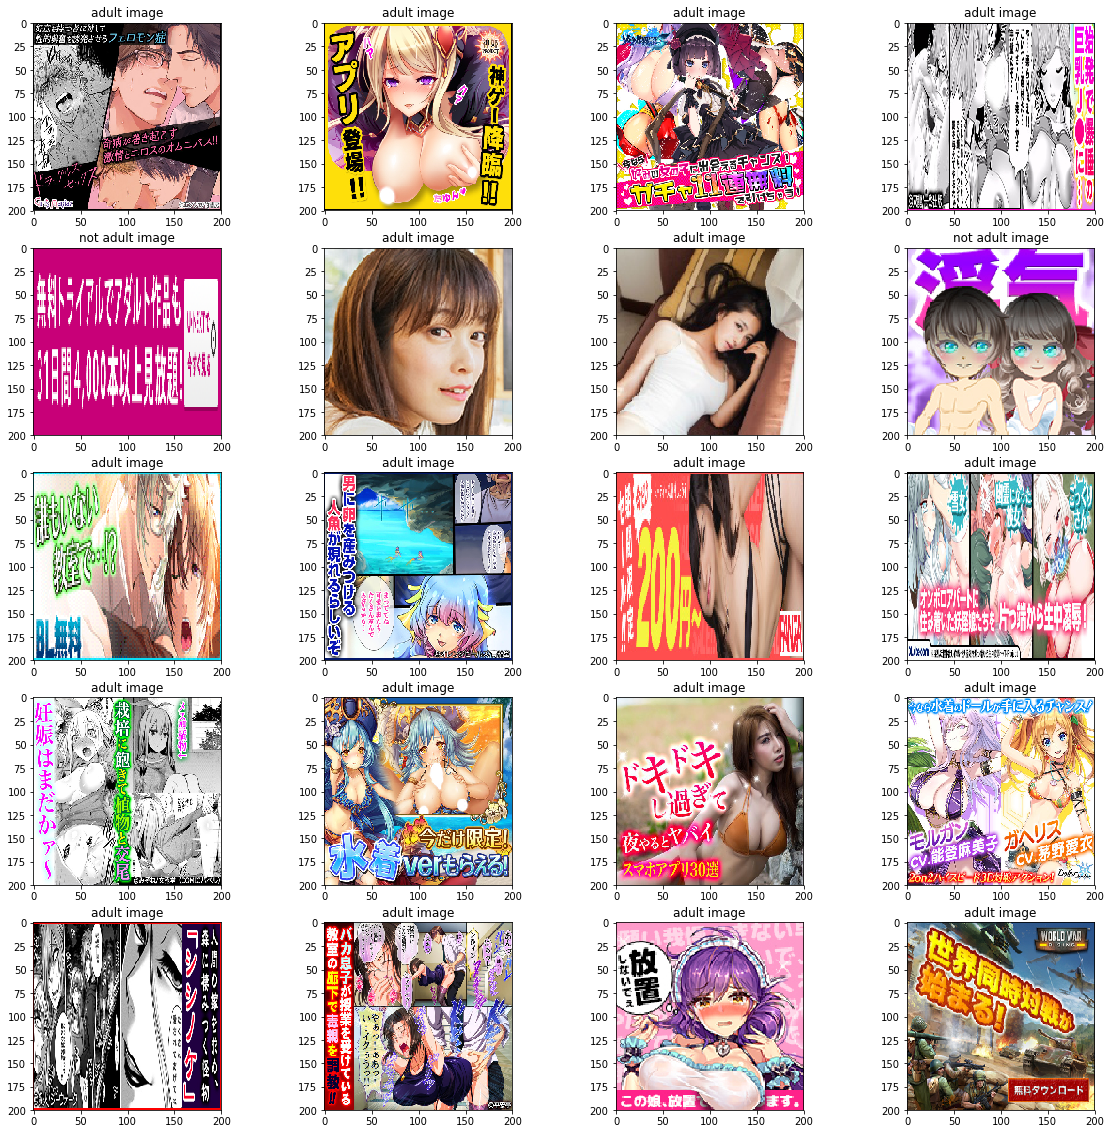

In [127]:
#view predict images
w=1
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5

test_df = testdf.query("label_name == 'adult'")
test_f_img = test_df[110:130]

for j, i in enumerate(test_f_img['path']):
    DIR = Path().cwd().joinpath('dataset')
    file = DIR.joinpath(i)
    img = load_img(file, target_size=(200,200))
    fig.add_subplot(rows, columns, j+1)
    x = img_to_array(img)
    x /= 255
    y_pred = model_to_eval.predict(x.reshape([-1,200,200,3]))
    
    
    if int(y_pred.argmax(axis = -1)) < 0.5:
        plt.title("adult image")
        plt.imshow(img)
    else:
        plt.title("not adult image")
        plt.imshow(img)
        
plt.show()

In [124]:
test_f

,filename,label_name,width,height,bytes,path
135538,2903855_6a7c8b2f836778a2a9fe1a68c9c25728906c2f...,not_adult,600,500,349224,not_adult/2903855_6a7c8b2f836778a2a9fe1a68c9c2...
173666,2999385_db393d9ea7e8e67f7f823fe0842f5773675f72...,adult,160,160,59590,adult/2999385_db393d9ea7e8e67f7f823fe0842f5773...
115300,2861738_efc0c92a75cafdffe36f6a09dbfe5c64c5416c...,not_adult,320,100,29362,not_adult/2861738_efc0c92a75cafdffe36f6a09dbfe...
241044,3153589_e7d0ae961676df061c83f324aea66a29e7550c...,not_adult,640,100,76619,not_adult/3153589_e7d0ae961676df061c83f324aea6...
92364,3391846_c7a6e3426a451b947752b03f9d2645dd698931...,adult,600,500,177116,adult/3391846_c7a6e3426a451b947752b03f9d2645dd...
149124,2928990_e8259b310736c14f6beebd8e0be500b4a0a974...,not_adult,600,500,190340,not_adult/2928990_e8259b310736c14f6beebd8e0be5...
126089,2886106_96bd28e574005a81ff36b479fba451791a6c7d...,not_adult,600,360,98166,not_adult/2886106_96bd28e574005a81ff36b479fba4...
60730,3325490_351f5cef6de8c8a58fd4168865910f04903bcc...,adult,640,200,70886,adult/3325490_351f5cef6de8c8a58fd4168865910f04...
46825,3292315_2120339014c95ccc7236aed231a15eacd26450...,not_adult,600,500,185024,not_adult/3292315_2120339014c95ccc7236aed231a1...
15680,3226928_1c4670ec534f059d989b2b304552b467f716c9...,not_adult,600,360,82244,not_adult/3226928_1c4670ec534f059d989b2b304552...


In [170]:
model.to_yaml

,filename,label_name,width,height,bytes,path
95,3190049_8a136f83bb6a1cf1311d601aeb9dc3985fce7a...,adult,600,500,221893,adult/3190049_8a136f83bb6a1cf1311d601aeb9dc398...
96,3190050_b1faf9e463bacd1f2fecc578e81a5fa3ca53e3...,adult,600,500,221893,adult/3190050_b1faf9e463bacd1f2fecc578e81a5fa3...
97,3190052_cf5e4b2f3eeb08a47cadc90c27d0f10c4ba464...,adult,600,500,221893,adult/3190052_cf5e4b2f3eeb08a47cadc90c27d0f10c...
98,3190053_78953b3804044d8b3a4ca1fbac1db83ceacf71...,adult,600,500,221893,adult/3190053_78953b3804044d8b3a4ca1fbac1db83c...
99,3190055_189353f2f707152a1720cf5d0654f47f76d35e...,adult,600,500,209260,adult/3190055_189353f2f707152a1720cf5d0654f47f...
100,3190056_42883ed481e9d46ad418a52ceb1833dd5ed697...,adult,600,500,209260,adult/3190056_42883ed481e9d46ad418a52ceb1833dd...
101,3190058_a765342f308f0393b9e856654e821ce04a82fa...,adult,600,500,209260,adult/3190058_a765342f308f0393b9e856654e821ce0...
102,3190059_b5740792e2f8fe7ef4ba462202894d52924b16...,adult,600,500,209260,adult/3190059_b5740792e2f8fe7ef4ba462202894d52...
103,3190061_423fec00a8ec3661c40e0a2c1219a8cec212f2...,adult,600,500,173224,adult/3190061_423fec00a8ec3661c40e0a2c1219a8ce...
104,3190062_0f8b5d28c65eed817b1f44fa3dc6584c81fc70...,adult,600,500,173224,adult/3190062_0f8b5d28c65eed817b1f44fa3dc6584c...


In [ ]:
135248 15386